In [1]:
import pandas as pd
import torch
import glob

import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
import sys
sys.path.append("../src")

import train
import scipy.stats
import sklearn.metrics

In [47]:
import numpy as np

In [3]:
from types import SimpleNamespace
sns.set_context('talk')

In [31]:
data_pt = torch.load("../data/Weinreb2020_fate/fate_test.pt")
x = data_pt['x']
y = data_pt['y']
t = data_pt['t']

Inspect training curves

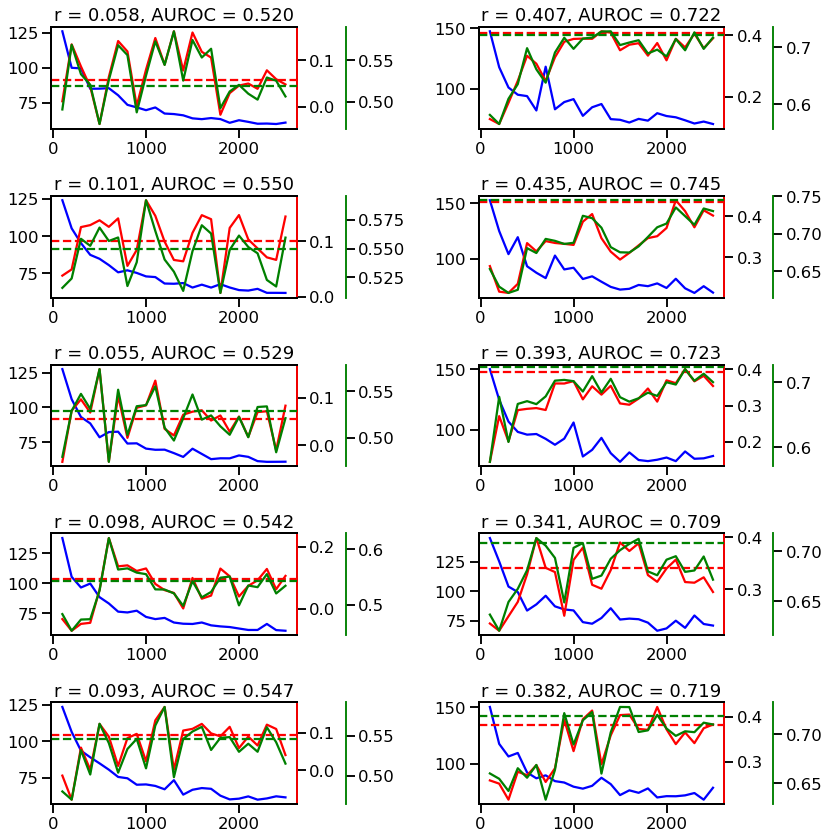

In [176]:
fig, axs = plt.subplots(5, 2, figsize = (12, 12))

paths = glob.glob("../experiments/weinreb-fate-train_batch-0.1/"
          "/all_none*/*/interpolate.log")

results = []

for ai, path in enumerate(sorted(paths)): 
    
    config_path = path.replace('interpolate.log', 'config.pt')
    config = SimpleNamespace(**torch.load(config_path))

    fate_path = path.replace('interpolate.log', 'fate.pt')
    fate_pt = torch.load(fate_path)
    scores = fate_pt['scores']
    scores_d = dict(zip([int(e) for e in 
        [e.split('_')[-1] for e in fate_pt['names']][1:]], 
        scores[1:]))

    rs = [scipy.stats.pearsonr(s, y)[0] for s in scores]
    aurocs = [sklearn.metrics.roc_auc_score(y > 0.5, s) for s in scores]

    log = pd.read_csv(path, sep = "\t")
    log = log.loc[log['epoch'] != 'best']
    log['epoch'] = log['epoch'].apply(lambda e: int(e.split('_')[1]))

    log_ = log.groupby(['epoch'])['loss'].sum()

    ax = axs[ai, 0]
    ax.plot(log_.index, log_.values, 'b-')

    ax2 = ax.twinx()
    ax2.plot(log_.index, rs[1:], 'r-')
    ax2.spines["right"].set_color('r')
    
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    ax3.spines["right"].set_color('g')
    ax3.plot(log_.index, aurocs[1:], 'g-')    
    
    # ensemble over last 5
    
    ensembled_scores = np.stack(scores[-5:], axis = 0).mean(axis = 0)
    last_ensembled_r = scipy.stats.pearsonr(ensembled_scores, y)[0]
    last_ensembled_auroc = sklearn.metrics.roc_auc_score(y > 0.5, ensembled_scores)
    last_ensembled_train = log_.tail(n = 5).mean()
    
    ax2.axhline(last_ensembled_r, color = 'r', linestyle = '--')
    ax3.axhline(last_ensembled_auroc, color = 'g', linestyle = '--')
    
    results.append(('none', config.seed, last_ensembled_r, last_ensembled_auroc, last_ensembled_train))
    
    ax.set_title('r = {:.3f}, AUROC = {:.3f}'.format(last_ensembled_r, last_ensembled_auroc))
    
plt.tight_layout() 

paths = glob.glob("../experiments/weinreb-fate-train_batch-0.1/"
          "/all_kegg*/*/interpolate.log")

last_ensembled_rs = []
last_ensembled_aurocs = []

for ai, path in enumerate(sorted(paths)): 
    
    config_path = path.replace('interpolate.log', 'config.pt')
    config = SimpleNamespace(**torch.load(config_path))

    fate_path = path.replace('interpolate.log', 'fate.pt')
    fate_pt = torch.load(fate_path)
    scores = fate_pt['scores']
    scores_d = dict(zip([int(e) for e in 
        [e.split('_')[-1] for e in fate_pt['names']][1:]], 
        scores[1:]))

    rs = [scipy.stats.pearsonr(s, y)[0] for s in scores]
    aurocs = [sklearn.metrics.roc_auc_score(y > 0.5, s) for s in scores]

    log = pd.read_csv(path, sep = "\t")
    log = log.loc[log['epoch'] != 'best']
    log['epoch'] = log['epoch'].apply(lambda e: int(e.split('_')[1]))

    log_ = log.groupby(['epoch'])['loss'].sum()

    ax = axs[ai, 1]
    ax.plot(log_.index, log_.values, 'b-')

    ax2 = ax.twinx()
    ax2.plot(log_.index, rs[1:], 'r-')
    ax2.spines["right"].set_color('r')
    
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    ax3.spines["right"].set_color('g')
    ax3.plot(log_.index, aurocs[1:], 'g-')    
    
    # ensemble over last 5
    
    ensembled_scores = np.stack(scores[-5:], axis = 0).mean(axis = 0)
    last_ensembled_r = scipy.stats.pearsonr(ensembled_scores, y)[0]
    last_ensembled_auroc = sklearn.metrics.roc_auc_score(y > 0.5, ensembled_scores)
    last_ensembled_train = log_.tail(n = 5).mean()
    
    ax2.axhline(last_ensembled_r, color = 'r', linestyle = '--')
    ax3.axhline(last_ensembled_auroc, color = 'g', linestyle = '--')
    
    results.append(('kegg', config.seed, last_ensembled_r, last_ensembled_auroc, last_ensembled_train))
    
    ax.set_title('r = {:.3f}, AUROC = {:.3f}'.format(last_ensembled_r, last_ensembled_auroc))
    
plt.tight_layout() 

In [177]:
pd.DataFrame(results, columns = ['weight', 'seed', 'r', 'auroc', 'train']).groupby(
    'weight')[['r', 'auroc', 'train']].describe().loc[:, pd.IndexSlice[:,['mean', 'std']]]

r               auroc                train          
            mean       std      mean       std       mean       std
weight                                                             
kegg    0.391469  0.034522  0.723462  0.013084  74.159789  1.853486
none    0.080973  0.022326  0.537330  0.012736  61.680189  0.858645